# Hierarchical clustering human trisome project PLIER model

Marc Subirana-Granés (2024)

Description

# Load libraries/modules

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from ccc.coef import ccc
from scipy.spatial.distance import squareform
import os
from pyprojroot.here import here
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# Load data

In [2]:
# define output nb
output_nb_path = here('output/nbs/hierarchical_clustering_human_trisome_project_plier_model')

if not os.path.exists(output_nb_path):
    os.makedirs(output_nb_path)

create_human_trisome_project_plier_model_path = here('output/nbs/create_human_trisome_project_plier_model/')

In [3]:
import os
import pandas as pd
import pickle

# Get a list of all files in the directory matching the pattern
files = [f for f in os.listdir(create_human_trisome_project_plier_model_path) if f.startswith('htp_plier_model') and f.endswith('Zmatrix.pkl')]

# Initialize a list to store the individual DataFrames
dataframes = []
model_info = []

# Loop through each file and process it
for idx, file in enumerate(files):
    # Load the Z-matrix from the pickle file
    file_path = os.path.join(create_human_trisome_project_plier_model_path, file)
    with open(file_path, 'rb') as f:
        z_matrix = pickle.load(f)
    
    # Extract data and rownames from the dictionary
    data = z_matrix['data']
    rownames = z_matrix['rownames']
    
    # Convert the data to a DataFrame and set row names
    df = pd.DataFrame(data, index=rownames)
    
    # Generate model name (e.g., M1, M2, ...)
    model_name = f'M{idx + 1}'
    
    # Add the model type and name to the model_info list
    model_info.append({'model_type': file, 'model_name': model_name})
    
    # Rename the columns of the DataFrame
    df.columns = [f'{model_name}_LV{i + 1}' for i in range(df.shape[1])]
    
    # Add the DataFrame to the list
    dataframes.append(df)

# Create the mapping DataFrame
mapping_df = pd.DataFrame(model_info)

# Concatenate all Z-matrix DataFrames
htp_models_combined = pd.concat(dataframes, axis=1)

In [4]:
htp_models_combined.shape

(36362, 2340)

In [5]:
htp_models_combined.head()

,M1_LV1,M1_LV2,M1_LV3,M1_LV4,M1_LV5,M1_LV6,M1_LV7,M1_LV8,M1_LV9,M1_LV10,...,M20_LV147,M20_LV148,M20_LV149,M20_LV150,M20_LV151,M20_LV152,M20_LV153,M20_LV154,M20_LV155,M20_LV156
GAS6,0.000000,0.021520,0.000000,0.000000,0.068108,0.686169,0.000000,0.013339,0.049694,0.000000,...,0.011094,0.055057,0.150583,0.077708,0.045537,0.021514,0.105647,0.097278,0.169503,0.088016
MMP14,0.009866,0.002741,0.000000,0.003944,0.007377,0.003229,0.000000,0.001321,0.000434,0.000000,...,0.052666,0.156279,0.043062,0.003004,0.008024,0.017663,0.048003,0.015524,0.077994,0.049532
MARCKSL1,1.907483,0.000000,0.276145,0.680140,0.461992,0.000000,0.000000,0.000000,0.663238,0.140629,...,0.153884,0.000000,0.000000,1.056987,0.000000,0.393206,0.000000,1.315569,0.647713,2.271203
SPARC,1.439544,0.425169,0.075883,0.395785,0.000000,0.000000,0.030413,1.399178,0.000000,0.000000,...,0.221609,0.224873,0.422590,0.235851,0.139482,0.061679,0.299608,0.009016,0.614439,0.123909
CTSD,1.455564,0.000000,0.553258,0.186374,0.606311,0.809921,0.000000,0.009646,0.631132,0.079644,...,0.000000,0.099967,0.000000,0.611111,0.460574,0.000000,0.162960,0.446065,0.000000,0.000000


In [6]:
def hierarchical_clustering(matrix, distance_threshold):
    
    # Corr
    correlation_matrix = matrix.corr()

    # Compute the distance matrix from the correlation matrix
    distance_matrix = 1 - correlation_matrix

    # Perform Agglomerative Clustering
    clustering = AgglomerativeClustering(n_clusters=None, metric='precomputed', linkage='complete', distance_threshold=distance_threshold)
    clusters = clustering.fit_predict(distance_matrix)

    # Create a DataFrame to store the clusters
    clusters_df = pd.DataFrame(clusters, columns=['cluster'])
    clusters_df.index = distance_matrix.index
    clusters_df['cluster'] = clusters_df['cluster'].apply(lambda x: 'CL' + str(x))

    # Reset index and rename columns
    new_clusters_df = clusters_df.reset_index().rename(columns={'index': 'LVs'})

    # Count the number of LVs in each cluster
    cluster_counts = clusters_df['cluster'].value_counts().reset_index()
    cluster_counts.columns = ['cluster', 'counts']

    # Merge cluster counts with the cluster DataFrame
    result_df = new_clusters_df.merge(cluster_counts, on='cluster', how='left')
    result_df = result_df.sort_values(by=['counts', 'cluster'], ascending=[False, False])

    # Get the order of LVs based on cluster counts
    lv_order = result_df['LVs'].tolist()
    lv_order = [lv for lv in lv_order if lv in distance_matrix.columns]

    # Reorder the distance matrix based on the new LV order
    ordered_distance_matrix = distance_matrix.reindex(index=lv_order, columns=lv_order)

    return ordered_distance_matrix, clusters_df, result_df

def visualize_clusters(distance_matrix, clusters_df, result_df, size_heatmap_n=None, font_scale=1, label_font_size=10):
    cmap_rg = LinearSegmentedColormap.from_list(
        name='test',
        colors=['#006400', '#DAF7A6', '#C70039']
    )

    # Order the clusters_df to match the ordered distance matrix
    ordered_clusters_df = clusters_df.loc[result_df['LVs']]

    # Assuming that 'cluster' column contains the cluster IDs
    num_unique_clusters = ordered_clusters_df['cluster'].nunique()
    palette = sns.color_palette("husl", num_unique_clusters)
    np.random.shuffle(palette)
    color_dict = dict(zip(ordered_clusters_df['cluster'].unique(), palette))

    # Map cluster labels to colors using the dictionary
    row_colors = ordered_clusters_df['cluster'].map(color_dict)

    sns.set(font_scale=font_scale)

    # Subset the distance matrix and row_colors if size_heatmap_n is specified
    if size_heatmap_n is not None:
        distance_matrix = distance_matrix.iloc[:size_heatmap_n, :size_heatmap_n]
        row_colors = row_colors.iloc[:size_heatmap_n]

    # Create the cluster map
    g = sns.clustermap(distance_matrix,
                       row_colors=row_colors,
                       figsize=(25, 25),
                       cmap=cmap_rg,
                       cbar_pos=None,
                       row_cluster=False,
                       col_cluster=False,
                       yticklabels=True,
                       xticklabels=True)

    # Adjust subplot parameters to remove white space
    g.fig.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)

    # Adjust the heatmap position if needed
    heatmap_position = [0.05, 0.05, 0.9, 0.9]
    g.ax_heatmap.set_position(heatmap_position)

    # If row colors are present, adjust their position to align with the heatmap
    if hasattr(g, 'ax_row_colors'):
        row_colors_position = [0.02, 0.05, 0.02, 0.9]
        g.ax_row_colors.set_position(row_colors_position)

    # Rotate the labels for better readability
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=label_font_size)
    plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=label_font_size)

    # Show the plot
    plt.show()

In [7]:
distance_threshold = 0.25
htp_models_ordered_distance_matrix, htp_models_clusters_df, htp_models_result_df = hierarchical_clustering(htp_models_combined, distance_threshold)

In [8]:
htp_models_ordered_distance_matrix.head()

,M1_LV35,M2_LV35,M3_LV35,M4_LV35,M5_LV35,M6_LV35,M7_LV35,M8_LV4,M8_LV35,M9_LV61,...,M10_LV188,M19_LV50,M20_LV154,M20_LV124,M17_LV138,M17_LV56,M12_LV127,M17_LV165,M17_LV168,M18_LV50
M1_LV35,0.000000,0.046918,0.019803,0.041342,0.058665,0.052070,0.044340,0.088742,0.037586,0.019263,...,0.962282,0.939840,0.845292,0.927829,0.970001,0.922625,0.900522,0.933214,0.929528,0.925308
M2_LV35,0.046918,0.000000,0.009251,0.003661,0.008426,0.002818,0.008985,0.086934,0.026405,0.066231,...,0.980529,0.985667,0.958945,0.980553,0.989590,0.945536,0.924236,0.981956,0.971073,0.979676
M3_LV35,0.019803,0.009251,0.000000,0.007698,0.017658,0.012331,0.012800,0.081172,0.020611,0.040119,...,0.969668,0.958698,0.905434,0.952933,0.982972,0.935601,0.901000,0.962613,0.956171,0.958003
M4_LV35,0.041342,0.003661,0.007698,0.000000,0.015528,0.005444,0.003995,0.090831,0.016431,0.053516,...,0.976514,0.983026,0.953051,0.978985,0.989991,0.947013,0.923569,0.981449,0.967396,0.975847
M5_LV35,0.058665,0.008426,0.017658,0.015528,0.000000,0.013632,0.029262,0.070132,0.050077,0.091906,...,0.967894,0.959011,0.932115,0.966703,0.991018,0.945668,0.880312,0.978601,0.956797,0.971991


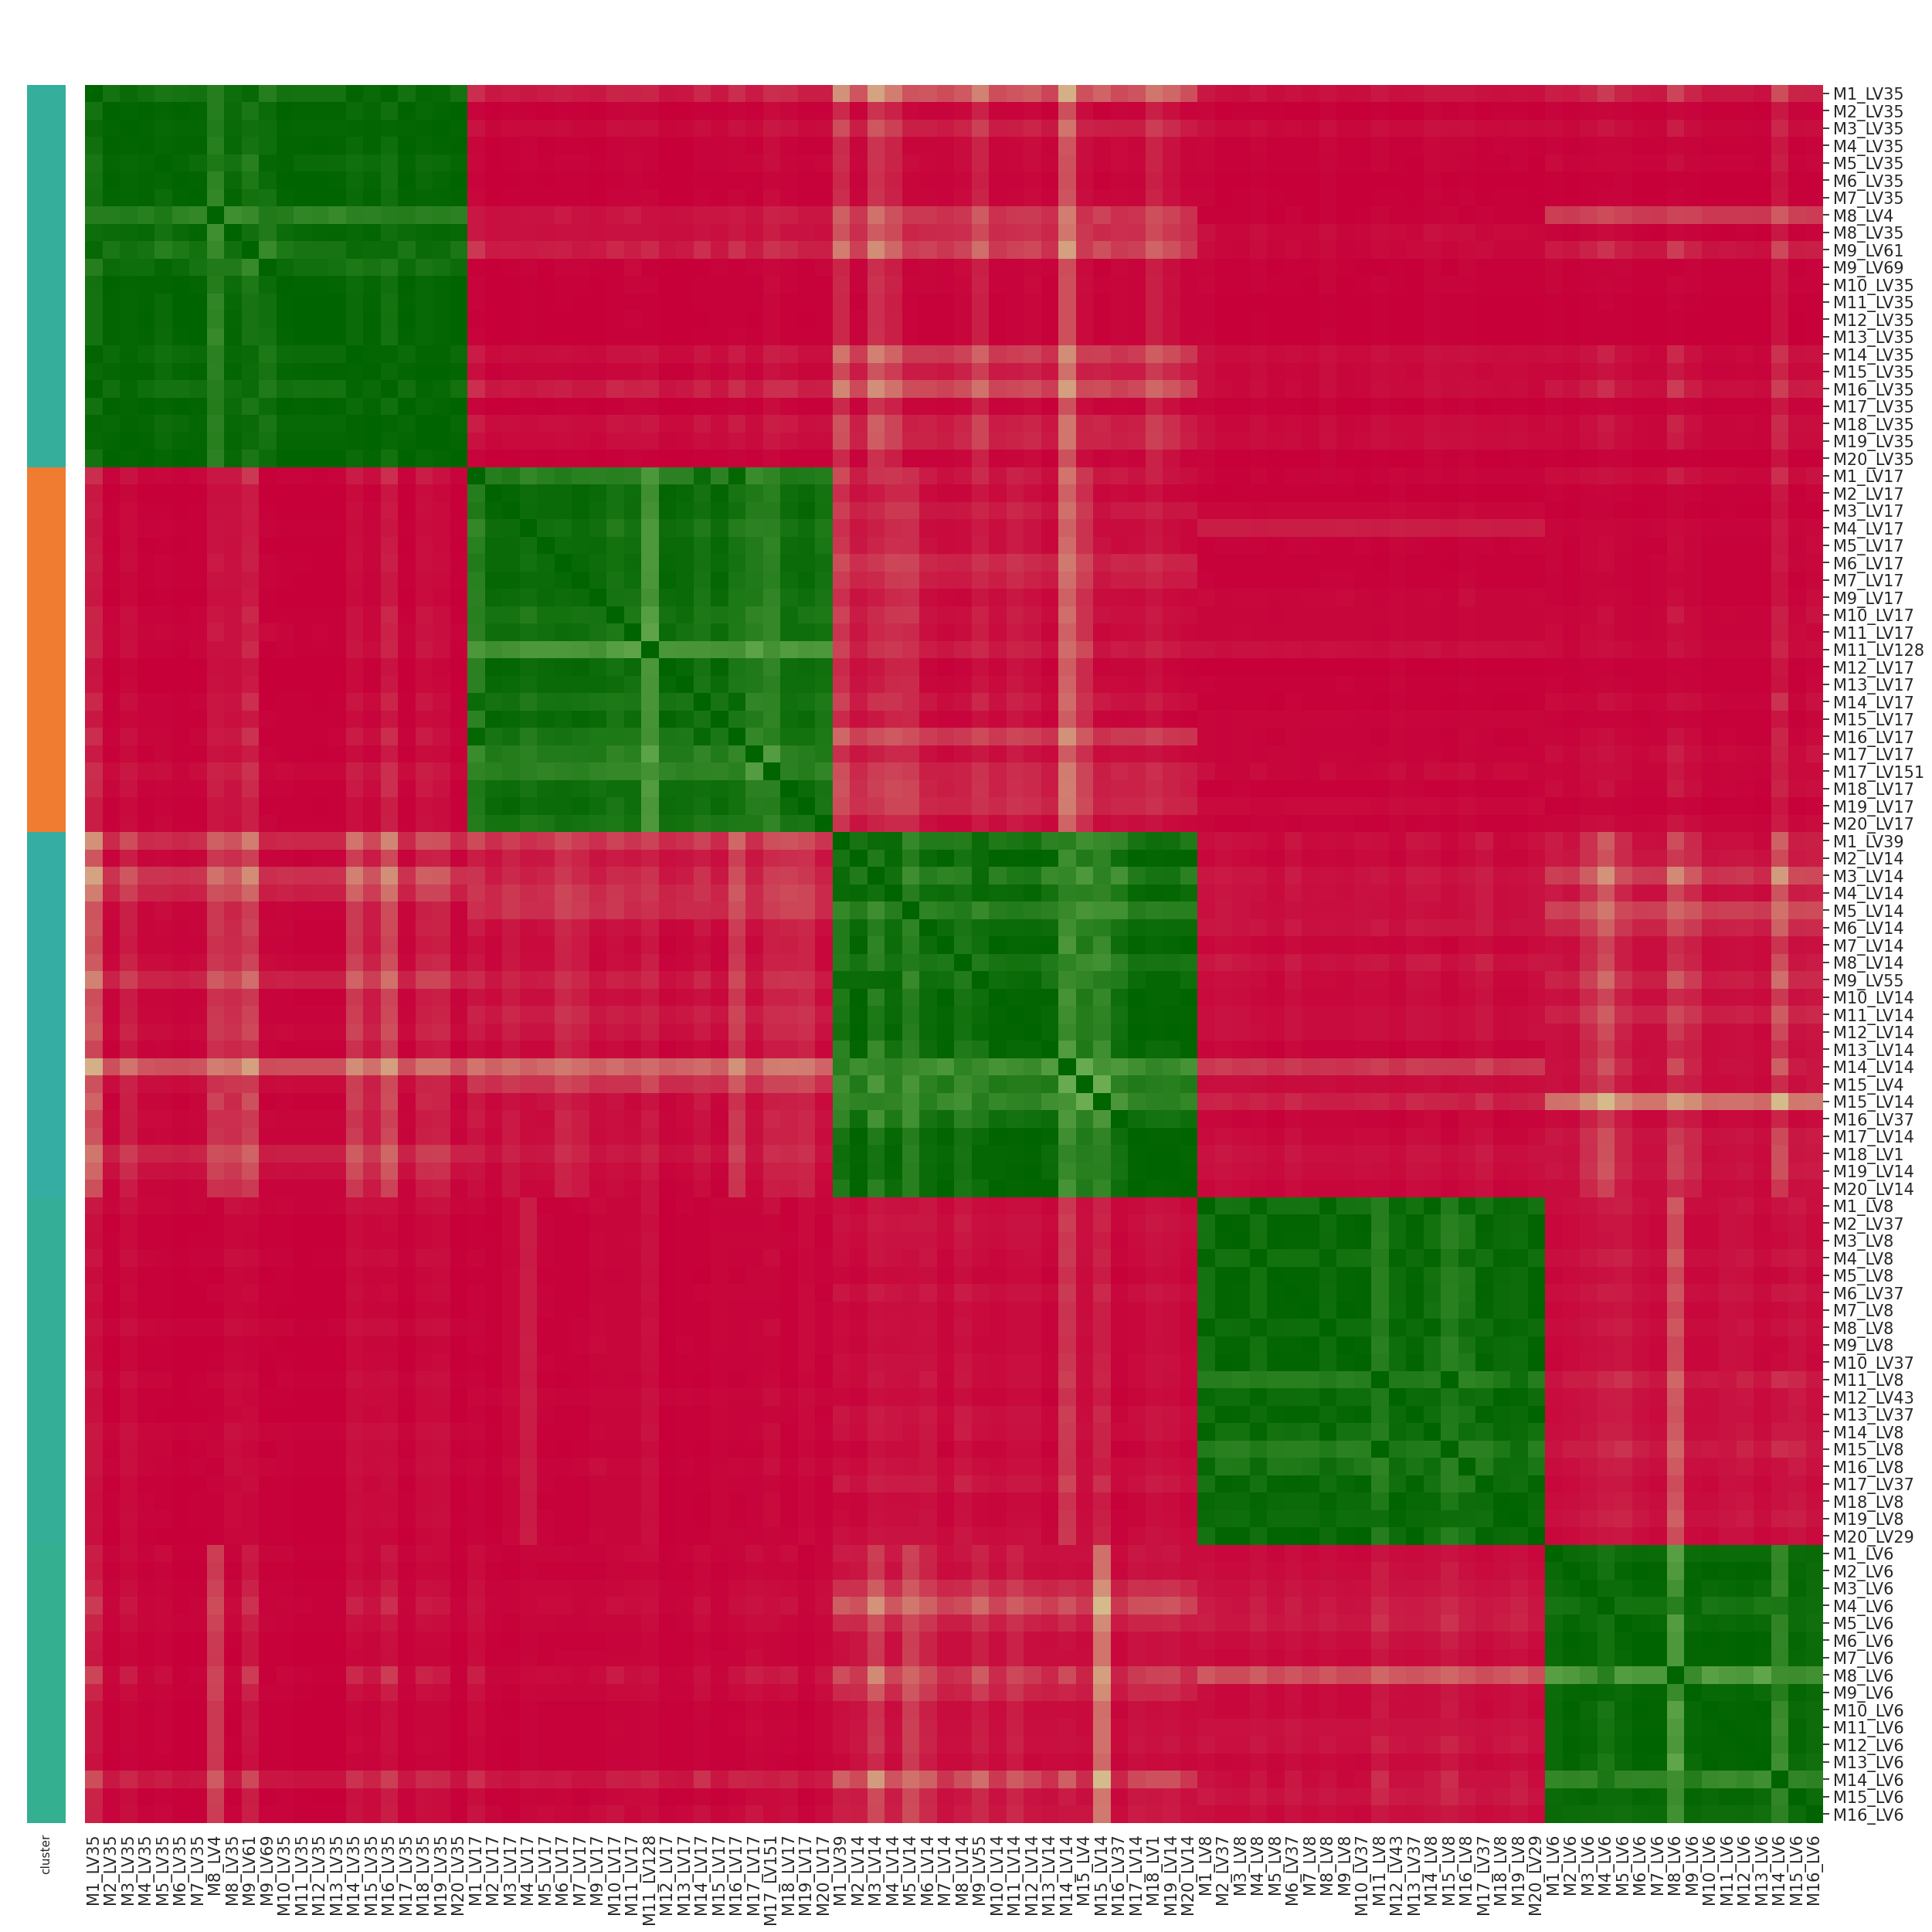

In [9]:
visualize_clusters(htp_models_ordered_distance_matrix, htp_models_clusters_df, htp_models_result_df, size_heatmap_n=100, font_scale=1, label_font_size=15)

In [10]:
htp_models_result_df['LVs'][htp_models_result_df['cluster'] == 'CL141']

34       M1_LV35
73       M2_LV35
268      M3_LV35
346      M4_LV35
424      M5_LV35
502      M6_LV35
658      M7_LV35
744       M8_LV4
775      M8_LV35
840      M9_LV61
848      M9_LV69
892     M10_LV35
1087    M11_LV35
1243    M12_LV35
1399    M13_LV35
1594    M14_LV35
1633    M15_LV35
1750    M16_LV35
1789    M17_LV35
1984    M18_LV35
2101    M19_LV35
2218    M20_LV35
Name: LVs, dtype: object

In [11]:
model_info_df = pd.DataFrame(model_info)

sel_model_name='M1'
sel_lv_name='LV35'

sel_model_type=model_info_df[model_info_df['model_name'] == sel_model_name]['model_type'].values[0]
Zmatrix_path = os.path.join(create_human_trisome_project_plier_model_path, sel_model_type)

with open(Zmatrix_path, 'rb') as f:
    z_matrix = pickle.load(f)
    z_data = z_matrix['data']
    df_z = pd.DataFrame(z_data)

df_z.head()

df_z.columns = [f'LV{i+1}' for i in range(len(df_z.columns))]

df_z[sel_lv_name]

GAS6          0.033810
MMP14         0.006283
MARCKSL1      1.508642
SPARC         0.000000
CTSD          0.841090
                ...   
ZSWIM8.AS1    0.011711
ZSWIM9        0.015773
ZUP1          0.009197
ZYG11AP1      0.000000
ZYXP1         0.000000
Name: LV35, Length: 36362, dtype: float64

In [162]:
# Filter htp_models_result_df for cluster 'CL141'
filtered_htp_df = htp_models_result_df[htp_models_result_df['cluster'] == 'CL141']

# Initialize an empty DataFrame to hold the combined results
s_combined_df = pd.DataFrame()

# Loop through each LV in the filtered_htp_df
for lv_entry in filtered_htp_df['LVs']:
    sel_model_name, sel_lv_name = lv_entry.split('_')
    
    # Get the corresponding model type
    sel_model_type = model_info_df[model_info_df['model_name'] == sel_model_name]['model_type'].values[0]
    Smatrix_path = sel_model_type.replace('Zmatrix', 'Smatrix')
    Smatrix_path = os.path.join(create_human_trisome_project_plier_model_path, Smatrix_path)

    # Load the S-matrix
    with open(Smatrix_path, 'rb') as f:
        s_matrix = pickle.load(f)
        s_data = s_matrix['data']
        df_summary = pd.DataFrame(s_data)

    # Rename the columns and apply the filtering
    df_summary.rename(columns={'LV index': 'LV'}, inplace=True)
    df_summary['LV'] = df_summary['LV'].apply(lambda x: f'LV{x}')
    df_summary = df_summary[(df_summary['LV'] == sel_lv_name) & (df_summary['AUC'] > 0.7) & (df_summary['FDR'] < 0.05)]
    df_summary['model'] = sel_model_name
    
    # Select the desired columns and append to combined_df
    s_combined_df = pd.concat([s_combined_df, df_summary[['model', 'LV', 'pathway', 'AUC', 'FDR']]])

s_combined_df

,model,LV,pathway,AUC,FDR
283,M1,LV35,SVM B cells memory,0.900895,9.119942e-07
284,M1,LV35,SVM Plasma cells,0.764564,3.205181e-03
285,M1,LV35,SVM T cells CD8,0.920699,8.862528e-08
286,M1,LV35,REACTOME_PEPTIDE_CHAIN_ELONGATION,0.833736,5.630069e-06
288,M1,LV35,TIEN_INTESTINE_PROBIOTICS_6HR_UP,0.830110,1.699803e-04
...,...,...,...,...,...
906,M20,LV35,GSE9006_HEALTHY_VS_TYPE_1_DIABETES_PBMC_AT_DX_DN,0.759460,2.225022e-08
907,M20,LV35,GSE29618_BCELL_VS_MONOCYTE_UP,0.907445,2.346312e-16
908,M20,LV35,GSE3337_CTRL_VS_16H_IFNG_IN_CD8POS_DC_DN,0.845077,1.072901e-12
909,M20,LV35,GSE10325_LUPUS_BCELL_VS_LUPUS_MYELOID_UP,0.903345,6.512154e-17


In [98]:
pathway_counts = df['pathway'].value_counts().reset_index()
pathway_counts.columns = ['pathway', 'count']
pathway_counts.head(100)

,pathway,count
0,JAATINEN_HEMATOPOIETIC_STEM_CELL_DN,13
1,REACTOME_PEPTIDE_CHAIN_ELONGATION,12
2,TIEN_INTESTINE_PROBIOTICS_6HR_UP,11
3,GNATENKO_PLATELET_SIGNATURE,11
4,MIPS_NOP56P_ASSOCIATED_PRE_RRNA_COMPLEX,9
5,CHAUHAN_RESPONSE_TO_METHOXYESTRADIOL_DN,8
6,REACTOME_3_UTR_MEDIATED_TRANSLATIONAL_REGULATION,8
7,REACTOME_NONSENSE_MEDIATED_DECAY_ENHANCED_BY_T...,7
8,KIM_LRRC3B_TARGETS,6
9,DIRMEIER_LMP1_RESPONSE_EARLY,6


In [ ]:
path_metadata_GSE190125 = here('data/GSE190125/metadata_GSE190125.csv')
metadata_GSE190125 = pd.read_csv(path_metadata_GSE190125)
metadata_GSE190125.columns = ['Group', 'Sample']
metadata_GSE190125.head()

In [152]:
model_info_df = pd.DataFrame(model_info)

sel_model_name = 'M1'
sel_lv_name = 'LV35'

sel_model_type = model_info_df[model_info_df['model_name'] == sel_model_name]['model_type'].values[0]
Bmatrix_path = sel_model_type.replace('Zmatrix', 'Bmatrix')
Bmatrix_path = os.path.join(create_human_trisome_project_plier_model_path, Bmatrix_path)

with open(Bmatrix_path, 'rb') as f:
    b_matrix = pickle.load(f)
    b_data = b_matrix['data']
    df_b = pd.DataFrame(b_data)

df_b['LV'] = df_b.index
df_b = df_b[['LV'] + [col for col in df_b.columns if col != 'LV']]
df_b.reset_index(drop=True, inplace=True)

lv_data_long = pd.melt(df_b, id_vars=['LV'], var_name='Sample', value_name='Value')
lv_data_long = lv_data_long.merge(metadata_GSE190125, on='Sample', how='left')

results = {'LV': [], 'statistic': [], 'p_value': []}

# Get unique LV values
lv_values = lv_data_long['LV'].unique()

# Perform the test for each LV
for lv in lv_values:
    # Filter the data for the current LV
    lv_data = lv_data_long[lv_data_long['LV'] == lv]
    
    # Separate the groups
    control_group = lv_data[lv_data['Group'] == 'Control']['Value']
    t21_group = lv_data[lv_data['Group'] == 'T21']['Value']
    
    # Perform the Wilcoxon rank-sum test
    stat, p = mannwhitneyu(control_group, t21_group, alternative='two-sided')
    
    # Store the results
    results['LV'].append(lv)
    results['statistic'].append(stat)
    results['p_value'].append(p)

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Adjust p-values using Benjamini-Hochberg method
adjusted_pvalues = multipletests(results_df['p_value'], method='fdr_bh')[1]

# Add the adjusted p-values to the DataFrame
results_df['adjusted_p_value'] = adjusted_pvalues

filtered_results_df = results_df[results_df['adjusted_p_value'] < 0.05].copy()
filtered_results_df['model'] = sel_model_name
first_values = filtered_results_df['LV'].str.split(',').str[0].str.replace('LV ', '')
first_values= 'LV' + first_values
filtered_results_df['LV'] = first_values
filtered_results_df = filtered_results_df[['model', 'LV', 'adjusted_p_value']]

In [159]:
# Filter htp_models_result_df for cluster 'CL141'
filtered_htp_df = htp_models_result_df[htp_models_result_df['cluster'] == 'CL141']

# Initialize an empty DataFrame to hold the combined results
b_combined_df = pd.DataFrame()

# Loop through each LV in the filtered_htp_df
for lv_entry in filtered_htp_df['LVs']:
    sel_model_name, sel_lv_name = lv_entry.split('_')
    
    # Get the corresponding model type
    sel_model_type = model_info_df[model_info_df['model_name'] == sel_model_name]['model_type'].values[0]
    Bmatrix_path = sel_model_type.replace('Zmatrix', 'Bmatrix')
    Bmatrix_path = os.path.join(create_human_trisome_project_plier_model_path, Bmatrix_path)

    # Load the B-matrix
    with open(Bmatrix_path, 'rb') as f:
        b_matrix = pickle.load(f)
        b_data = b_matrix['data']
        df_b = pd.DataFrame(b_data)

    # Prepare the DataFrame for analysis
    df_b['LV'] = df_b.index
    df_b = df_b[['LV'] + [col for col in df_b.columns if col != 'LV']]
    df_b.reset_index(drop=True, inplace=True)
    
    # Melt the DataFrame for easier manipulation
    lv_data_long = pd.melt(df_b, id_vars=['LV'], var_name='Sample', value_name='Value')
    lv_data_long = lv_data_long.merge(metadata_GSE190125, on='Sample', how='left')

    # Prepare results dictionary
    results = {'LV': [], 'statistic': [], 'p_value': []}

    # Get unique LV values
    lv_values = lv_data_long['LV'].unique()

    # Perform the test for each LV
    for lv in lv_values:
        # Filter the data for the current LV
        lv_data = lv_data_long[lv_data_long['LV'] == lv]
        
        # Separate the groups
        control_group = lv_data[lv_data['Group'] == 'Control']['Value']
        t21_group = lv_data[lv_data['Group'] == 'T21']['Value']
        
        # Perform the Wilcoxon rank-sum test
        stat, p = mannwhitneyu(control_group, t21_group, alternative='two-sided')
        
        # Store the results
        results['LV'].append(lv)
        results['statistic'].append(stat)
        results['p_value'].append(p)

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)

    # Adjust p-values using Benjamini-Hochberg method
    adjusted_pvalues = multipletests(results_df['p_value'], method='fdr_bh')[1]

    # Add the adjusted p-values to the DataFrame
    results_df['adjusted_p_value'] = adjusted_pvalues

    # Filter the results based on adjusted p-values
    filtered_results_df = results_df[results_df['adjusted_p_value'] < 0.05].copy()
    filtered_results_df['model'] = sel_model_name
    first_values = filtered_results_df['LV'].str.split(',').str[0].str.replace('LV ', '')
    first_values= 'LV' + first_values
    filtered_results_df['LV'] = first_values
    filtered_results_df = filtered_results_df[['model', 'LV', 'adjusted_p_value']]

    # Append the filtered results to combined_df
    b_combined_df = pd.concat([b_combined_df, filtered_results_df])

b_combined_df


,model,LV,adjusted_p_value
0,M1,LV1,1.759276e-02
1,M1,LV2,9.490847e-05
2,M1,LV3,1.209139e-03
6,M1,LV7,4.253493e-03
7,M1,LV8,2.029127e-07
...,...,...,...
148,M20,LV149,2.238135e-03
150,M20,LV151,4.219125e-02
153,M20,LV154,9.049095e-03
154,M20,LV155,2.726930e-07


In [160]:
b_combined_df.head()

,model,LV,adjusted_p_value
0,M1,LV1,1.759276e-02
1,M1,LV2,9.490847e-05
2,M1,LV3,1.209139e-03
6,M1,LV7,4.253493e-03
7,M1,LV8,2.029127e-07


In [163]:
s_combined_df.head()

,model,LV,pathway,AUC,FDR
283,M1,LV35,SVM B cells memory,0.900895,9.119942e-07
284,M1,LV35,SVM Plasma cells,0.764564,3.205181e-03
285,M1,LV35,SVM T cells CD8,0.920699,8.862528e-08
286,M1,LV35,REACTOME_PEPTIDE_CHAIN_ELONGATION,0.833736,5.630069e-06
288,M1,LV35,TIEN_INTESTINE_PROBIOTICS_6HR_UP,0.830110,1.699803e-04


In [165]:
s_b_combined_df = pd.merge(b_combined_df, s_combined_df, on=['model', 'LV'], how='inner')

In [166]:
print(s_b_combined_df)

    model    LV  adjusted_p_value  \
0      M1  LV35          0.017420   
1      M1  LV35          0.017420   
2      M1  LV35          0.017420   
3      M1  LV35          0.017420   
4      M1  LV35          0.017420   
..    ...   ...               ...   
333   M20  LV35          0.010167   
334   M20  LV35          0.010167   
335   M20  LV35          0.010167   
336   M20  LV35          0.010167   
337   M20  LV35          0.010167   

                                              pathway       AUC           FDR  
0                                  SVM B cells memory  0.900895  9.119942e-07  
1                                    SVM Plasma cells  0.764564  3.205181e-03  
2                                     SVM T cells CD8  0.920699  8.862528e-08  
3                   REACTOME_PEPTIDE_CHAIN_ELONGATION  0.833736  5.630069e-06  
4                    TIEN_INTESTINE_PROBIOTICS_6HR_UP  0.830110  1.699803e-04  
..                                                ...       ...           .

In [167]:
pathway_counts = s_b_combined_df['pathway'].value_counts().reset_index()
pathway_counts.columns = ['pathway', 'count']
pathway_counts.head(100)

,pathway,count
0,DANG_MYC_TARGETS_UP,20
1,WU_HBX_TARGETS_1_UP,20
2,GSE29618_BCELL_VS_MONOCYTE_UP,20
3,HELLER_HDAC_TARGETS_SILENCED_BY_METHYLATION_DN,19
4,HELLER_HDAC_TARGETS_DN,19
5,GSE3337_CTRL_VS_16H_IFNG_IN_CD8POS_DC_DN,18
6,GSE29618_BCELL_VS_MDC_DAY7_FLU_VACCINE_UP,17
7,GOLDRATH_NAIVE_VS_EFF_CD8_TCELL_DN,17
8,SVM B cells memory,16
9,SVM Plasma cells,16


# Agglomerative approach as a transfer learning 

Use agglomerative approach with the HTP models and Multiplier models to transfer learing. 

Since the Multiplier model has less genes first is necessary keep the genes only present in both types of models.

In [31]:
htp_models_combined.head()

,M1_LV1,M1_LV2,M1_LV3,M1_LV4,M1_LV5,M1_LV6,M1_LV7,M1_LV8,M1_LV9,M1_LV10,...,M20_LV147,M20_LV148,M20_LV149,M20_LV150,M20_LV151,M20_LV152,M20_LV153,M20_LV154,M20_LV155,M20_LV156
GAS6,0.000000,0.021520,0.000000,0.000000,0.068108,0.686169,0.000000,0.013339,0.049694,0.000000,...,0.011094,0.055057,0.150583,0.077708,0.045537,0.021514,0.105647,0.097278,0.169503,0.088016
MMP14,0.009866,0.002741,0.000000,0.003944,0.007377,0.003229,0.000000,0.001321,0.000434,0.000000,...,0.052666,0.156279,0.043062,0.003004,0.008024,0.017663,0.048003,0.015524,0.077994,0.049532
MARCKSL1,1.907483,0.000000,0.276145,0.680140,0.461992,0.000000,0.000000,0.000000,0.663238,0.140629,...,0.153884,0.000000,0.000000,1.056987,0.000000,0.393206,0.000000,1.315569,0.647713,2.271203
SPARC,1.439544,0.425169,0.075883,0.395785,0.000000,0.000000,0.030413,1.399178,0.000000,0.000000,...,0.221609,0.224873,0.422590,0.235851,0.139482,0.061679,0.299608,0.009016,0.614439,0.123909
CTSD,1.455564,0.000000,0.553258,0.186374,0.606311,0.809921,0.000000,0.009646,0.631132,0.079644,...,0.000000,0.099967,0.000000,0.611111,0.460574,0.000000,0.162960,0.446065,0.000000,0.000000


In [38]:
multiplier_Z_path = here('data/multiplier/multiplier_model_z.pkl')

with open(multiplier_Z_path, 'rb') as f:
    multiplier_Z = pickle.load(f)
    
multiplier_Z.rename(columns=lambda x: 'multiplier_' + x if x.startswith('LV') else x, inplace=True)

multiplier_Z.head()



,multiplier_LV1,multiplier_LV2,multiplier_LV3,multiplier_LV4,multiplier_LV5,multiplier_LV6,multiplier_LV7,multiplier_LV8,multiplier_LV9,multiplier_LV10,...,multiplier_LV978,multiplier_LV979,multiplier_LV980,multiplier_LV981,multiplier_LV982,multiplier_LV983,multiplier_LV984,multiplier_LV985,multiplier_LV986,multiplier_LV987
GAS6,0.000000,0.0,0.039438,0.0,0.050476,0.000000,0.0,0.000000,0.590949,0.000000,...,0.050125,0.00000,0.033407,0.000000,0.000000,0.005963,0.347362,0.0,0.000000,0.000000
MMP14,0.000000,0.0,0.000000,0.0,0.070072,0.000000,0.0,0.004904,1.720179,2.423595,...,0.000000,0.00000,0.001007,0.000000,0.035747,0.000000,0.000000,0.0,0.014978,0.000000
DSP,0.000000,0.0,0.000000,0.0,0.000000,0.041697,0.0,0.005718,0.000000,0.000000,...,0.020853,0.00000,0.000000,0.000000,0.000000,0.005774,0.000000,0.0,0.000000,0.416405
MARCKSL1,0.305212,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.161843,0.149471,...,0.027134,0.05272,0.000000,0.030189,0.060884,0.000000,0.000000,0.0,0.000000,0.448480
SPARC,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.014014,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.067779,0.0,0.122417,0.062665


In [41]:
import tempfile

# Create temporary files
htp_models_filtered_file = tempfile.NamedTemporaryFile(delete=False)
multiplier_filtered_file = tempfile.NamedTemporaryFile(delete=False)

# Filter row names in htp_models_combined and save to temporary file
htp_models_combined_filtered = htp_models_combined[htp_models_combined.index.isin(multiplier_Z.index)]
htp_models_combined_filtered.to_csv(htp_models_filtered_file.name)

# Filter row names in multiplier_Z and save to temporary file
multiplier_Z_filtered = multiplier_Z[multiplier_Z.index.isin(htp_models_combined.index)]
multiplier_Z_filtered.to_csv(multiplier_filtered_file.name)

# Read the filtered dataframes from the temporary files
htp_models_combined_filtered = pd.read_csv(htp_models_filtered_file.name, index_col=0)
multiplier_Z_filtered = pd.read_csv(multiplier_filtered_file.name, index_col=0)

# Combine the filtered dataframes
htp_models_multi_combined = pd.concat([multiplier_Z_filtered, htp_models_combined_filtered], ignore_index=True)

htp_models_multi_combined = pd.concat([multiplier_Z, htp_models_combined], ignore_index=True)

htp_models_multi_combined.head()


,multiplier_LV1,multiplier_LV2,multiplier_LV3,multiplier_LV4,multiplier_LV5,multiplier_LV6,multiplier_LV7,multiplier_LV8,multiplier_LV9,multiplier_LV10,...,M20_LV147,M20_LV148,M20_LV149,M20_LV150,M20_LV151,M20_LV152,M20_LV153,M20_LV154,M20_LV155,M20_LV156
0,0.000000,0.0,0.039438,0.0,0.050476,0.000000,0.0,0.000000,0.590949,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.0,0.000000,0.0,0.070072,0.000000,0.0,0.004904,1.720179,2.423595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.0,0.000000,0.0,0.000000,0.041697,0.0,0.005718,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.305212,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.161843,0.149471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.014014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
htp_models_multi_combined.head()

,multiplier_LV1,multiplier_LV2,multiplier_LV3,multiplier_LV4,multiplier_LV5,multiplier_LV6,multiplier_LV7,multiplier_LV8,multiplier_LV9,multiplier_LV10,...,M20_LV147,M20_LV148,M20_LV149,M20_LV150,M20_LV151,M20_LV152,M20_LV153,M20_LV154,M20_LV155,M20_LV156
0,0.000000,0.0,0.039438,0.0,0.050476,0.000000,0.0,0.000000,0.590949,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,0.0,0.000000,0.0,0.070072,0.000000,0.0,0.004904,1.720179,2.423595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,0.0,0.000000,0.0,0.000000,0.041697,0.0,0.005718,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.305212,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.161843,0.149471,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.014014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
